imports

In [134]:

### open lib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os
import datetime

# Spark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, TimestampType, IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import col, desc, month, year, date_format, desc, sum

Setup local SparkSession

In [2]:
# Ensures proper Python worker binding
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

# Point to the JDBC driver
jdbc_jar_path = "C:\\Program Files\\Java\\sqljdbc_12.10\\enu\\jars\\mssql-jdbc.jar"

# Start Spark session with JDBC driver
spark = SparkSession.builder \
    .appName("SQLServerAccess") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "localhost") \
    .config("spark.network.timeout", "100s") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.jars", jdbc_jar_path) \
    .getOrCreate()


Read from staging

In [3]:
# SQL Server connection config
jdbc_url = (
    "jdbc:sqlserver://localhost:1433;"
    "databaseName=sqldb_staging;"
    "integratedSecurity=true;"
    "encrypt=true;"
    "trustServerCertificate=true"
)

connection_props = {
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

In [4]:
category = spark.read.jdbc(url=jdbc_url, table="dbo.category", properties=connection_props)
records = spark.read.jdbc(url=jdbc_url, table="dbo.records", properties=connection_props)

Data transformation

In [136]:
# display(records)

df = records.withColumn('year_month', date_format("timestamp", "yyyy-MM")).groupBy('year_month').pivot("type").agg({"amount": "sum"})
df = df.withColumn("closing_balance", col("income")+col("expenses"))

window_spec = Window.orderBy("year_month")
df = df.withColumn("balance_running_total", sum("closing_balance").over(window_spec))

display(df)

DataFrame[year_month: string, Expenses: double, Income: double, closing_balance: double, balance_running_total: double]

Begin Plot

In [141]:
data = df.collect()
x = [i.year_month for i in data]
y1 = [i.Income for i in data]
y2 = [i.Expenses for i in data]
y3 = [i.closing_balance for i in data]
y4 = [i.balance_running_total for i in data]

In [140]:
fontdict = {
    'fontname': 'Century Gothic'
    ,'color': '#525252'
    ,'verticalalignment': 'baseline'
 }

fontdict2 = {
    'fontname': 'Century Gothic'
    ,'fontsize': 8
    ,'color': '#525252'
    ,'verticalalignment': 'baseline'
 }

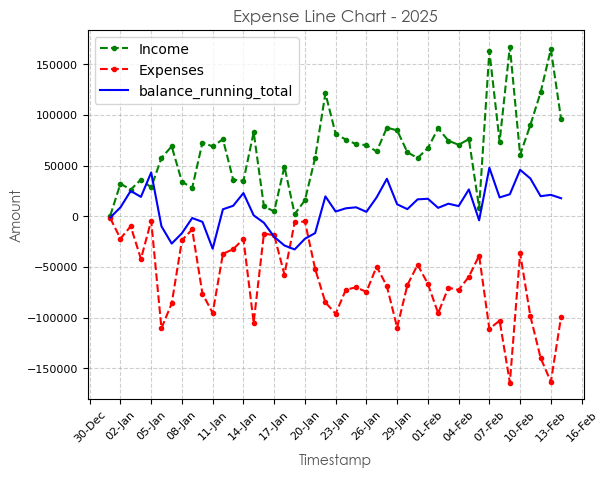

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot - shorthand - ColorMarkerLine
plt.plot(x, y1, 'g.--', label='Income')
plt.plot(x, y2, 'r.--', label='Expenses')
# plt.plot(x, y3, label='closing_balance', color='#525252', linewidth=1, linestyle='--', marker='.', markersize=5, markeredgecolor='#525252')
plt.plot(x, y4, 'b-', label='balance_running_total')

# Description
plt.title('Expense Line Chart - 2025', fontdict=fontdict)
plt.xlabel('Timestamp', fontdict=fontdict, labelpad=15)
plt.ylabel('Amount', fontdict=fontdict)
plt.legend()

# Set locator & formatter
locator = mdates.DayLocator(interval=3)
formatter = mdates.DateFormatter('%d-%b')
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)

# Additional formatting
ax.grid(True, linestyle='--', alpha=0.6)
fig = plt.figure()
plt.tight_layout()

plt.show()

In [ ]:
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x000001FD29FAE1D0>>